In [13]:
# adding import which is required for excecuting code
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.optimize import linear_sum_assignment
import time

from IPython.display import display  # for dataframe

# importing sklearn packages 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from sklearn.manifold import TSNE
import matplotlib.gridspec as gridspec

In [14]:
# dataset laoding in the correct name
Dataset_destination = Path("UCI HAR Dataset")
# to able to reproduce
RANDOM_SEED = 42
USE_TSNE_INPUT = "raw"   # keepinf raw can change to pca50 later

In [15]:
# Auto-selection grids (equal budget per method)
K_GRID               = list(range(3, 12))   # 3..11
DBSCAN_MINPTS_CAND   = [5, 10, 15]
DBSCAN_EPS_MULTS     = [0.9, 1.0, 1.1]
DBSCAN_Q             = 0.80

# Dimension across config 
DIM_CHANGE = [2, 5, 10, 15, 20, 30, 40, 50, 60, 80, 100]
K_TRUE = 6

#general parameters like font ,width and colours
mpl.rcParams.update({
    "font.size": 12, "axes.labelsize": 12,
    "legend.fontsize": 10.5, "xtick.labelsize": 11, "ytick.labelsize": 11,
    "axes.grid": True, "grid.linestyle": ":", "grid.alpha": 0.6,
    "axes.spines.top": False, "axes.spines.right": False,
})
palette = {"kmeans":"#0072B2","agg-ward":"#E69F00","gmm":"#009E73","dbscan":"#D55E00"}

def style_axes(ax, integer_x=False):
    if integer_x:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(True, linestyle=":", alpha=0.6)

# a helper function to get data without the noisy points
def _mask_nonnoise(X, labels):
    z = np.asarray(labels)
    m = (z != -1)
    if m.sum() < 2 or len(np.unique(z[m])) < 2:
        return None, None
    return X[m], z[m]

# calculate the adjusted rand score but ignore any noise points
def ari_nonnoise(y, labels):
    labs = np.asarray(labels); m = (labs != -1)
    return adjusted_rand_score(np.asarray(y)[m], labs[m]) if m.any() else np.nan

# calculate the calinski harabasz score safely ignoring noise
def ch_safe(X, labels):
    Xm, zm = _mask_nonnoise(X, labels)
    return float(calinski_harabasz_score(Xm, zm)) if Xm is not None else np.nan

# calculate the davies bouldin score safely ignoring noise
def dbi_safe(X, labels):
    Xm, zm = _mask_nonnoise(X, labels)
    return float(davies_bouldin_score(Xm, zm)) if Xm is not None else np.nan

In [16]:
# a function to load the human activity recognition dataset

def load_har_split(base: Path):
    X_train = np.loadtxt(base / "train" / "X_train.txt")
    y_train = np.loadtxt(base / "train" / "y_train.txt").astype(int).ravel()
    X_test  = np.loadtxt(base / "test"  / "X_test.txt")
    y_test  = np.loadtxt(base / "test"  / "y_test.txt").astype(int).ravel()
    return X_train, y_train, X_test, y_test

# a function to create different views of the data like raw and pca
def make_views_from_train(X_tr, X_te, n_pcs=50):
    scaler = StandardScaler().fit(X_tr)
    Xtr_s  = scaler.transform(X_tr)
    Xte_s  = scaler.transform(X_te)
    pca    = PCA(n_components=n_pcs, random_state=RANDOM_SEED).fit(Xtr_s)
    Xtr_p  = pca.transform(Xtr_s)
    Xte_p  = pca.transform(Xte_s)
    return {"raw_tr": Xtr_s, "raw_te": Xte_s, "pca_tr": Xtr_p, "pca_te": Xte_p}

X_tr_raw, y_tr, X_te_raw, y_te = load_har_split(Dataset_destination)
views = make_views_from_train(X_tr_raw, X_te_raw)
pca_training_data, Xp_te = views["pca_tr"], views["pca_te"]

# print the shape of our pca transformed training and testing data
print("TRAIN:", pca_training_data.shape, "TEST:", Xp_te.shape)


TRAIN: (7352, 50) TEST: (2947, 50)


In [17]:
# show the shape of the raw training features and also displaying some rows 
print("X_train shape:", X_tr_raw.shape)
print("y_train shape:", y_tr.shape)
print("First 5 rows, first 8 cols of X_train:\n", X_tr_raw[:5, :8])
print("First 10 labels of y_train:", y_tr[:10])

X_train shape: (7352, 561)
y_train shape: (7352,)
First 5 rows, first 8 cols of X_train:
 [[ 0.28858451 -0.02029417 -0.13290514 -0.9952786  -0.98311061 -0.91352645
  -0.99511208 -0.98318457]
 [ 0.27841883 -0.01641057 -0.12352019 -0.99824528 -0.97530022 -0.96032199
  -0.99880719 -0.97491437]
 [ 0.27965306 -0.01946716 -0.11346169 -0.99537956 -0.96718701 -0.97894396
  -0.99651994 -0.96366837]
 [ 0.27917394 -0.02620065 -0.12328257 -0.99609149 -0.9834027  -0.9906751
  -0.99709947 -0.98274984]
 [ 0.27662877 -0.01656965 -0.11536185 -0.99813862 -0.98081727 -0.99048163
  -0.99832113 -0.97967187]]
First 10 labels of y_train: [5 5 5 5 5 5 5 5 5 5]


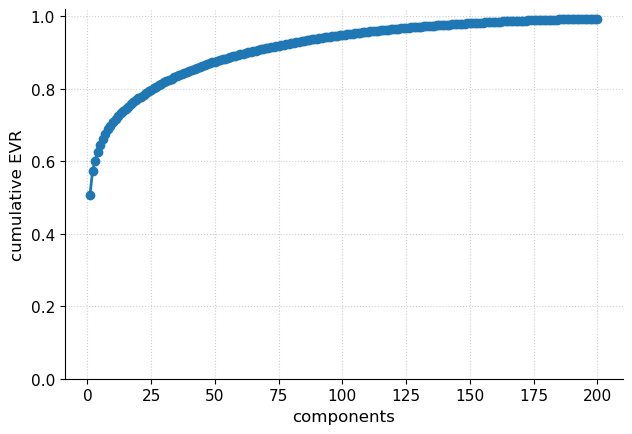

,component,cum_evr
0,1,0.507812
1,2,0.573619
2,3,0.601683
3,4,0.626722
4,5,0.645605
5,6,0.662845
6,7,0.676555
7,8,0.688546
8,9,0.698505
9,10,0.708156


In [18]:
 # scale all the raw training data before doing pca and display the table of first 50 compenents
Xs = StandardScaler().fit_transform(X_tr_raw)
pca_all = PCA(n_components=min(200, Xs.shape[1]), random_state=RANDOM_SEED).fit(Xs)
cum = np.cumsum(pca_all.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(7.2,4.8))
ax.plot(np.arange(1, len(cum)+1), cum, marker="o", linewidth=2)
ax.set_ylim(0, 1.02)
ax.set_xlabel("components"); ax.set_ylabel("cumulative EVR")
style_axes(ax, integer_x=True)
plt.show()

evr_df = pd.DataFrame({"component": np.arange(1, len(cum)+1),
                       "cum_evr": cum})
display(evr_df.head(50))


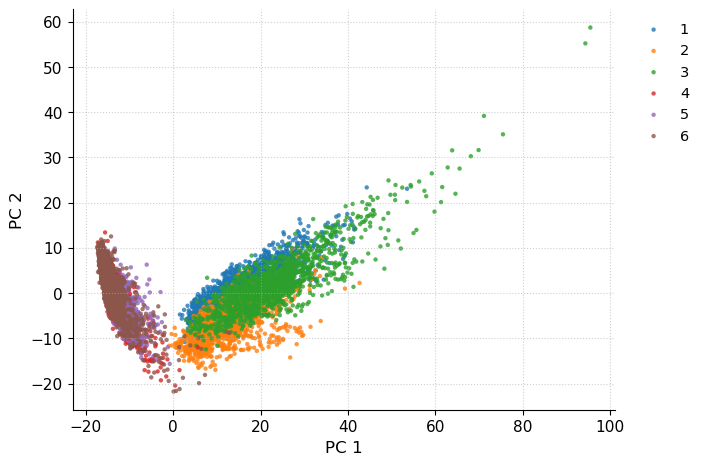

In [19]:
# combine the training and testing pca data into one big array and displaying pca 2 just to see the pattern with true lables

Xp_full = np.vstack([pca_training_data, Xp_te])
y_full  = np.concatenate([y_tr, y_te])
pca2 = Xp_full[:, :2]

fig, ax = plt.subplots(figsize=(7.0,5.2))
classes = np.array(sorted(np.unique(y_full)))
colors = plt.cm.tab10(np.linspace(0,1,max(10,len(classes))))
for i,c in enumerate(classes):
    m = (y_full==c)
    ax.scatter(pca2[m,0], pca2[m,1], s=10, alpha=0.8, color=colors[i], label=str(c), edgecolors="none")
ax.set_xlabel("PC 1"); ax.set_ylabel("PC 2")
style_axes(ax); ax.legend(frameon=False, bbox_to_anchor=(1.02,1), loc="upper left")
plt.show()


In [20]:
# defining all methods and auto select parameters using ch and dbi
def fit_kmeans_model(X, k):
    t0 = time.perf_counter()
    lab = KMeans(n_clusters=k, n_init=10, algorithm="elkan", max_iter=500,
                 random_state=RANDOM_SEED).fit_predict(X)
    return lab, time.perf_counter() - t0

def fit_ward(X, k):
    t0 = time.perf_counter()
    lab = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(X)
    return lab, time.perf_counter() - t0

def fit_gmm(X, k):
    t0 = time.perf_counter()
    gmm = GaussianMixture(n_components=k, covariance_type="full", n_init=3, reg_covar=1e-6,
                          max_iter=300, random_state=RANDOM_SEED).fit(X)
    lab = gmm.predict(X)
    return lab, time.perf_counter() - t0

def fit_dbscan(X, eps, minpts):
    t0 = time.perf_counter()
    lab = DBSCAN(eps=float(eps), min_samples=int(minpts)).fit_predict(X)
    return lab, time.perf_counter() - t0

def estimate_dbscan_eps(X, k_neighbors=10, q=DBSCAN_Q):
    nn = NearestNeighbors(n_neighbors=k_neighbors).fit(X)
    kth = np.sort(nn.kneighbors(X)[0][:, -1])
    return float(np.quantile(kth, q))

def _rank_sum(rows):
    df = pd.DataFrame(rows)
    df["CH_rank"]  = df["CH"].rank(ascending=False, method="average").fillna(len(df)*1.5)
    df["DBI_rank"] = df["DBI"].rank(ascending=True,  method="average").fillna(len(df)*1.5)
    df["rank_sum"] = df["CH_rank"] + df["DBI_rank"]
    return df.sort_values("rank_sum")

def select_kmeans_fair(X_tr):
    rows=[]
    for k in K_GRID:
        lab,_ = fit_kmeans_model(X_tr,k)
        rows.append({"k":k,"lab":lab,"CH":ch_safe(X_tr,lab),"DBI":dbi_safe(X_tr,lab)})
    best = _rank_sum(rows).iloc[0]
    lab, rt = fit_kmeans_model(X_tr, int(best["k"]))
    return lab, {"k":int(best["k"]), "runtime_s":rt}

def select_ward_fair(X_tr):
    rows=[]
    for k in K_GRID:
        lab,_=fit_ward(X_tr,k)
        rows.append({"k":k,"lab":lab,"CH":ch_safe(X_tr,lab),"DBI":dbi_safe(X_tr,lab)})
    best = _rank_sum(rows).iloc[0]
    lab, rt = fit_ward(X_tr, int(best["k"]))
    return lab, {"k":int(best["k"]), "runtime_s":rt}

def select_gmm_fair(X_tr):
    rows=[]
    for k in K_GRID:
        lab,_=fit_gmm(X_tr,k)
        rows.append({"k":k,"lab":lab,"CH":ch_safe(X_tr,lab),"DBI":dbi_safe(X_tr,lab)})
    best = _rank_sum(rows).iloc[0]
    lab, rt = fit_gmm(X_tr, int(best["k"]))
    return lab, {"k":int(best["k"]), "runtime_s":rt}

def select_dbscan_fair(X_tr):
    rows=[]
    for minpts in DBSCAN_MINPTS_CAND:
        eps0 = estimate_dbscan_eps(X_tr, k_neighbors=minpts)
        for mult in DBSCAN_EPS_MULTS:
            eps = float(eps0 * mult)
            lab,_ = fit_dbscan(X_tr, eps, minpts)
            rows.append({"eps":eps,"minPts":minpts,"lab":lab,
                         "CH":ch_safe(X_tr,lab),"DBI":dbi_safe(X_tr,lab)})
    best = _rank_sum(rows).iloc[0]
    lab, rt = fit_dbscan(X_tr, float(best["eps"]), int(best["minPts"]))
    return lab, {"eps":float(best["eps"]), "min_samples":int(best["minPts"]), "runtime_s":rt}

# run selection
kmeans_training_labels,  kmeans_model_info  = select_kmeans_fair(pca_training_data)
ward_training_labels,  ward_model_info  = select_ward_fair(pca_training_data)
gmm_training_labels,  gmm_model_info  = select_gmm_fair(pca_training_data)
dbscan_training_labels,  dbscan_model_info = select_dbscan_fair(pca_training_data)

display(pd.DataFrame.from_dict(
    {"kmeans":kmeans_model_info,"agg-ward":ward_model_info,"gmm":gmm_model_info,"dbscan":dbscan_model_info}, orient="index"
))


,k,runtime_s,eps,min_samples
kmeans,3.0,0.416705,NaN,NaN
agg-ward,3.0,4.505748,NaN,NaN
gmm,3.0,15.115658,NaN,NaN
dbscan,NaN,0.945026,11.841785,15.0


In [21]:
# testing all methods to the unseen data 

def _predict_by_centroid(X_train, lab_train, X_test):
    uniq = np.array(sorted(np.unique(lab_train)))
    C = np.vstack([X_train[lab_train == u].mean(axis=0) for u in uniq])
    D = ((X_test[:, None, :] - C[None, :, :])**2).sum(axis=2)
    return uniq[np.argmin(D, axis=1)]

def dbscan_inductive_predict(db_model, X_train, lab_train, X_test, eps):
    core_idx = getattr(db_model, "core_sample_indices_", None)
    if core_idx is None or len(core_idx) == 0:
        return np.full(X_test.shape[0], -1, dtype=int)
    core_pts = X_train[core_idx]
    core_lab = np.asarray(lab_train)[core_idx]
    nbrs = NearestNeighbors(radius=eps).fit(core_pts)
    neigh = nbrs.radius_neighbors(X_test, return_distance=False)
    y_pred = np.full(X_test.shape[0], -1, dtype=int)
    for i, inds in enumerate(neigh):
        if len(inds) == 0: continue
        labs = core_lab[inds]; labs = labs[labs != -1]
        if labs.size:
            vals, counts = np.unique(labs, return_counts=True)
            y_pred[i] = vals[np.argmax(counts)]
    return y_pred

# KM
km = KMeans(n_clusters=kmeans_model_info["k"], n_init=10, algorithm="elkan",
            max_iter=500, random_state=RANDOM_SEED).fit(pca_training_data)
yhat_tr_km = km.labels_
yhat_te_km = km.predict(Xp_te)

# Ward
yhat_tr_wa = ward_training_labels
yhat_te_wa = _predict_by_centroid(pca_training_data, yhat_tr_wa, Xp_te)

# GMM
gmm = GaussianMixture(n_components=gmm_model_info["k"], covariance_type="full",
                      n_init=3, reg_covar=1e-6, max_iter=300,
                      random_state=RANDOM_SEED).fit(pca_training_data)
yhat_tr_gm = gmm.predict(pca_training_data)
yhat_te_gm = gmm.predict(Xp_te)

# DBSCAN
db  = DBSCAN(eps=dbscan_model_info["eps"], min_samples=dbscan_model_info["min_samples"]).fit(pca_training_data)
yhat_tr_db = dbscan_training_labels
yhat_te_db = dbscan_inductive_predict(db, pca_training_data, yhat_tr_db, Xp_te, eps=dbscan_model_info["eps"])

labels_te  = {"kmeans": yhat_te_km, "agg-ward": yhat_te_wa, "gmm": yhat_te_gm, "dbscan": yhat_te_db}
labels_all = {
    "kmeans": np.concatenate([yhat_tr_km, yhat_te_km]),
    "agg-ward": np.concatenate([yhat_tr_wa, yhat_te_wa]),
    "gmm": np.concatenate([yhat_tr_gm, yhat_te_gm]),
    "dbscan": np.concatenate([yhat_tr_db, yhat_te_db]),
}


In [22]:
#displaying the table for ari with and without noise and nmi

summary_df = pd.DataFrame([{
    "method": m,
    "ARI": adjusted_rand_score(y_te, labels_te[m]),
    "ARI_nonnoise": ari_nonnoise(y_te, labels_te[m]),
    "NMI": normalized_mutual_info_score(y_te, labels_te[m]),
    "noise_fraction": float(np.mean(np.asarray(labels_te[m]) == -1)),
    "runtime_s": {"kmeans":kmeans_model_info,"agg-ward":ward_model_info,"gmm":gmm_model_info,"dbscan":dbscan_model_info}[m]["runtime_s"]
} for m in ["kmeans","agg-ward","gmm","dbscan"]])

display(summary_df)


,method,ARI,ARI_nonnoise,NMI,noise_fraction,runtime_s
0,kmeans,0.335804,0.335804,0.532821,0.000000,0.416705
1,agg-ward,0.329791,0.329791,0.538573,0.000000,4.505748
2,gmm,0.311025,0.311025,0.503254,0.000000,15.115658
3,dbscan,0.308638,0.316059,0.465668,0.236512,0.945026


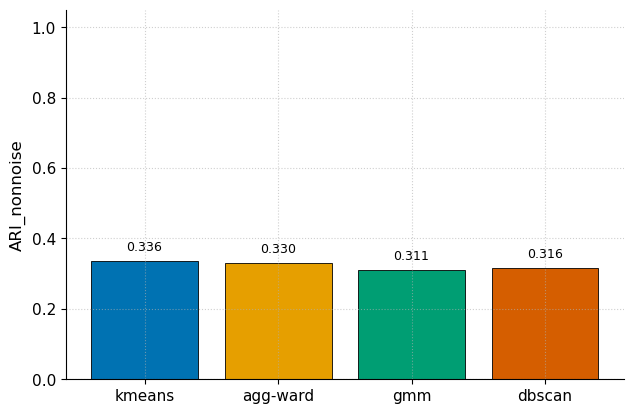

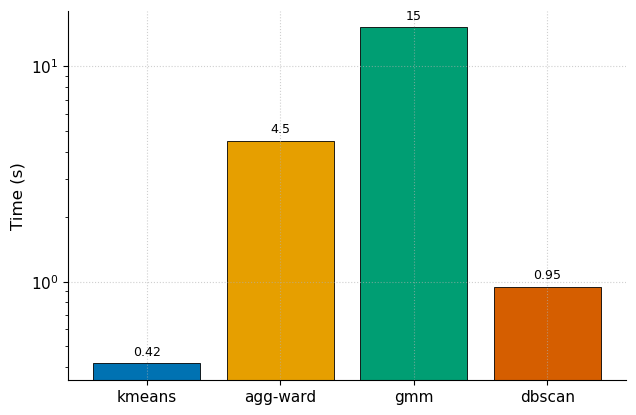

In [23]:
# plotting bar plots for the above table 
order = ["kmeans","agg-ward","gmm","dbscan"]
# ARI_nonnoise
fig, ax = plt.subplots(figsize=(7.2,4.8))
vals = [summary_df.loc[summary_df["method"]==m,"ARI_nonnoise"].item() for m in order]
ax.bar(order, vals, edgecolor="black", linewidth=0.6, color=[palette[m] for m in order])
ax.set_ylim(0, 1.05); ax.set_ylabel("ARI_nonnoise")
for i,v in enumerate(vals):
    if np.isfinite(v): ax.text(i, v+0.02, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
style_axes(ax); plt.show()

# Runtime (log)
fig, ax = plt.subplots(figsize=(7.2,4.8))
vals = [summary_df.loc[summary_df["method"]==m,"runtime_s"].item() for m in order]
ax.bar(order, vals, edgecolor="black", linewidth=0.6, color=[palette[m] for m in order])
ax.set_yscale("log"); ax.set_ylabel("Time (s)")
for i,v in enumerate(vals):
    if np.isfinite(v): ax.text(i, v*1.05, f"{v:.2g}", ha="center", va="bottom", fontsize=9)
style_axes(ax); plt.show()


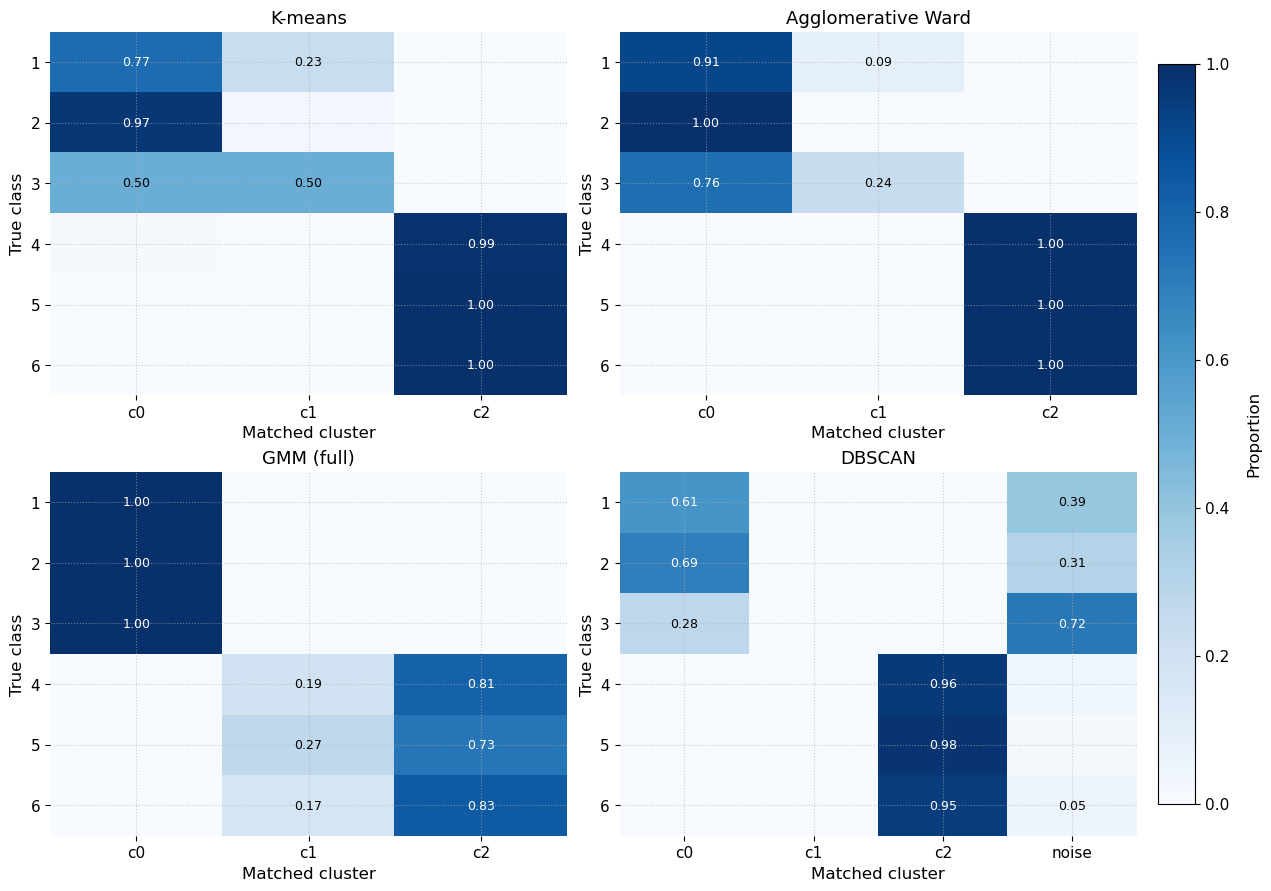

In [24]:
#plotting confusion matrix to understand clearly

def matched_confusion_with_noise(y_true, labels, include_noise=True):
    y = np.asarray(y_true).astype(int)
    z = np.asarray(labels)
    classes = np.array(sorted(np.unique(y)))
    pred_all   = np.array(sorted(np.unique(z)))
    pred_clean = np.array([u for u in pred_all if u != -1])
    row_map = {c:i for i,c in enumerate(classes)}
    col_map_all = {c:j for j,c in enumerate(pred_all)}
    C_full = np.zeros((len(classes), len(pred_all)), dtype=int)
    for yt, yp in zip(y, z):
        C_full[row_map[yt], col_map_all[yp]] += 1
    if pred_clean.size > 0:
        C_clean = C_full[:, [col_map_all[c] for c in pred_clean]]
        _, col_ind = linear_sum_assignment(C_clean.max() - C_clean)
        Cm_clean = C_clean[:, col_ind]
        col_labels_clean = pred_clean[col_ind]
    else:
        Cm_clean = np.zeros((len(classes), 0), dtype=int)
        col_labels_clean = np.array([], dtype=int)
    if include_noise and (-1 in pred_all):
        noise_col = C_full[:, [col_map_all[-1]]]
        Cm = np.hstack([Cm_clean, noise_col])
        col_labels = np.concatenate([col_labels_clean, np.array([-1])])
    else:
        Cm = Cm_clean; col_labels = col_labels_clean
    totals = C_full.sum(axis=1, keepdims=True).astype(float)
    totals[totals == 0] = 1.0
    M = Cm / totals
    names = [f"c{j}" for j in range(len(col_labels))]
    if include_noise and (-1 in col_labels): names[-1] = "noise"
    return M, names


order  = ["kmeans","agg-ward","gmm","dbscan"]
titles = {"kmeans":"K-means","agg-ward":"Agglomerative Ward","gmm":"GMM (full)","dbscan":"DBSCAN"}

fig = plt.figure(figsize=(12.6, 8.8), layout="constrained")
gs  = gridspec.GridSpec(2, 2, figure=fig)
axes = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]
cmap = mpl.cm.Blues
last_im=None
for ax, name in zip(axes, order):
    cm, col_labels = matched_confusion_with_noise(y_te, labels_te[name], include_noise=True)
    last_im = ax.imshow(cm, vmin=0.0, vmax=1.0, cmap=cmap, aspect="auto")
    ax.set_title(titles[name], fontsize=13, pad=6)  # method name only
    ax.set_xlabel("Matched cluster"); ax.set_ylabel("True class")
    ax.set_xticks(range(len(col_labels))); ax.set_xticklabels(col_labels)
    classes = sorted(np.unique(y_te)); ax.set_yticks(range(len(classes))); ax.set_yticklabels([str(c) for c in classes])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            v = cm[i, j]
            if v < 0.04: continue
            ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9, color=("white" if v > 0.55 else "black"))
    for sp in ax.spines.values(): sp.set_visible(False)
cbar = fig.colorbar(last_im, ax=axes, location="right", shrink=0.92, pad=0.02)
cbar.ax.set_ylabel("Proportion", rotation=90, labelpad=12)
plt.show()


In [25]:
# checking overifiting for all methods by ari and other metrices

meta_all = {"kmeans":kmeans_model_info, "agg-ward":ward_model_info, "gmm":gmm_model_info, "dbscan":dbscan_model_info}

def overfit_df(y_tr, y_te, labels_tr, labels_te, X_tr, X_te, meta):
    rows = []
    for m in ["kmeans","agg-ward","gmm","dbscan"]:
        z_tr = np.asarray(labels_tr[m]); z_te = np.asarray(labels_te[m])
        k_eff_tr = int(np.sum(np.unique(z_tr) != -1))
        k_eff_te = int(np.sum(np.unique(z_te) != -1))
        noise_tr = float(np.mean(z_tr == -1)); noise_te = float(np.mean(z_te == -1))
        CH_tr, DBI_tr = ch_safe(X_tr, z_tr), dbi_safe(X_tr, z_tr)
        CH_te, DBI_te = ch_safe(X_te, z_te), dbi_safe(X_te, z_te)
        ARI_tr,  ARInn_tr,  NMI_tr  = adjusted_rand_score(y_tr, z_tr),  ari_nonnoise(y_tr, z_tr),  normalized_mutual_info_score(y_tr, z_tr)
        ARI_te,  ARInn_te,  NMI_te  = adjusted_rand_score(y_te, z_te),  ari_nonnoise(y_te, z_te),  normalized_mutual_info_score(y_te, z_te)
        rows.append({
            "method": m, **{f"param_{k}": v for k, v in meta[m].items()},
            "k_eff_train": k_eff_tr, "noise_frac_train": noise_tr, "CH_train": CH_tr, "DBI_train": DBI_tr,
            "ARI_train": ARI_tr, "ARI_nonnoise_train": ARInn_tr, "NMI_train": NMI_tr,
            "k_eff_test": k_eff_te, "noise_frac_test": noise_te, "CH_test": CH_te, "DBI_test": DBI_te,
            "ARI_test": ARI_te, "ARI_nonnoise_test": ARInn_te, "NMI_test": NMI_te,
            "gap_ARI": ARI_tr - ARI_te, "gap_ARI_nonnoise": ARInn_tr - ARInn_te, "gap_NMI": NMI_tr - NMI_te,
            "ratio_ARI_nonnoise": (ARInn_te / ARInn_tr) if ARInn_tr > 0 else np.nan
        })
    return pd.DataFrame(rows)

ov_df = overfit_df(
    y_tr, y_te,
    labels_tr={"kmeans": yhat_tr_km, "agg-ward": yhat_tr_wa, "gmm": yhat_tr_gm, "dbscan": yhat_tr_db},
    labels_te=labels_te,
    X_tr=pca_training_data, X_te=Xp_te, meta=meta_all
)

display(ov_df)


,method,param_k,param_runtime_s,k_eff_train,noise_frac_train,CH_train,DBI_train,ARI_train,ARI_nonnoise_train,NMI_train,...,DBI_test,ARI_test,ARI_nonnoise_test,NMI_test,gap_ARI,gap_ARI_nonnoise,gap_NMI,ratio_ARI_nonnoise,param_eps,param_min_samples
0,kmeans,3.0,0.416705,3,0.000000,4788.616839,1.505125,0.327840,0.327840,0.517243,...,1.509644,0.335804,0.335804,0.532821,-0.007964,-0.007964,-0.015578,1.024293,NaN,NaN
1,agg-ward,3.0,4.505748,3,0.000000,4427.322714,1.485340,0.322712,0.322712,0.523599,...,1.436523,0.329791,0.329791,0.538573,-0.007079,-0.007079,-0.014974,1.021936,NaN,NaN
2,gmm,3.0,15.115658,3,0.000000,3948.861230,1.784439,0.301045,0.301045,0.474065,...,2.042884,0.311025,0.311025,0.503254,-0.009981,-0.009981,-0.029190,1.033154,NaN,NaN
3,dbscan,NaN,0.945026,7,0.181311,1262.140494,1.076197,0.325339,0.322880,0.483357,...,0.819364,0.308638,0.316059,0.465668,0.016701,0.006820,0.017689,0.978877,11.841785,15.0


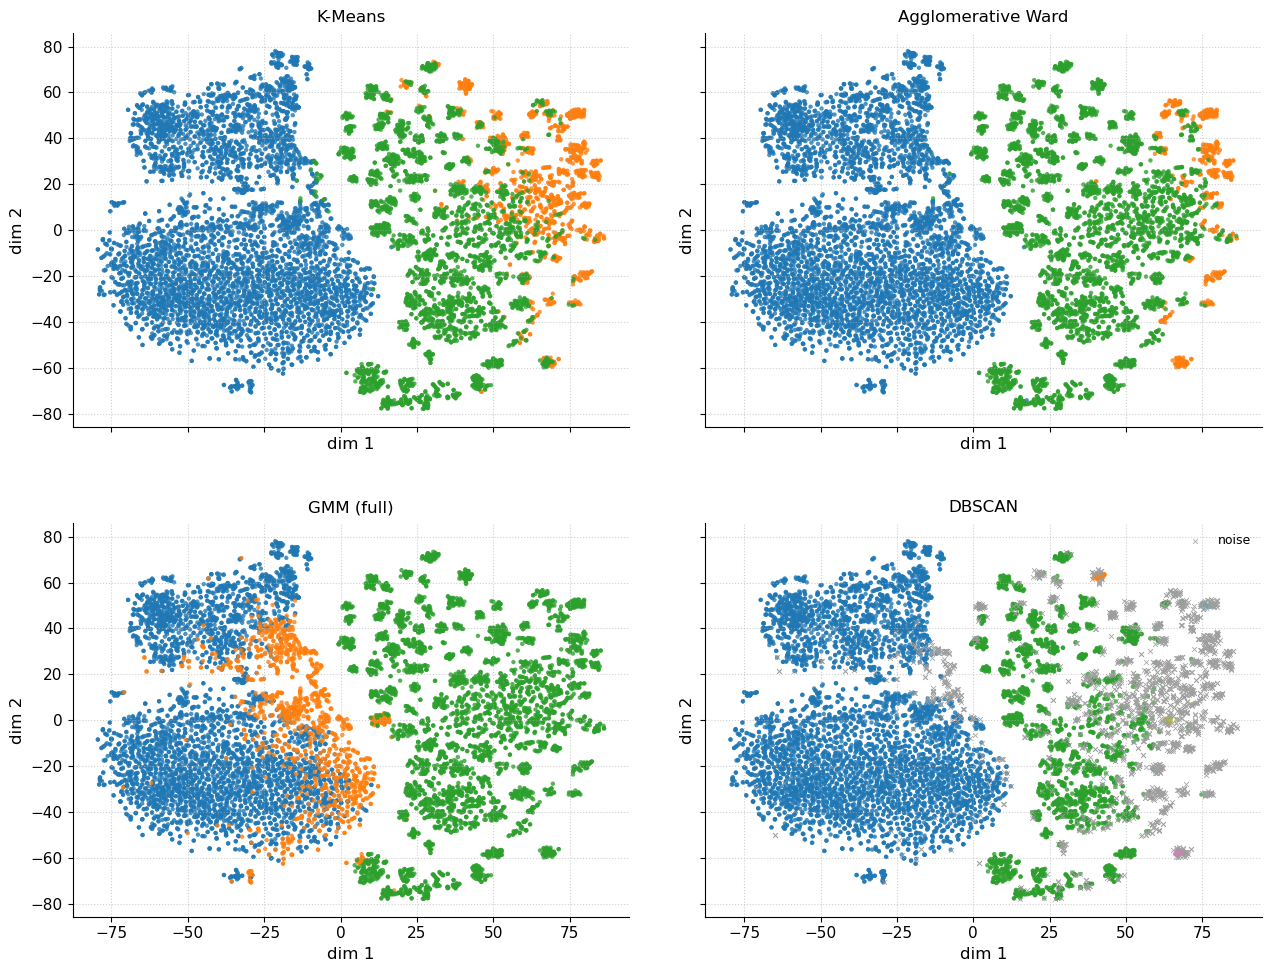

In [26]:

# Build combined views for t-SNE
views_all = {
    "raw":   np.vstack([views["raw_tr"], views["raw_te"]]),
    "pca50": np.vstack([pca_training_data, Xp_te]),
}

# pick the source; fallback to pca50 if unknown
Zsrc = views_all.get(USE_TSNE_INPUT, views_all["pca50"])

# Compute embedding (same random_state for reproducibility)
tsne2 = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    learning_rate="auto",
    n_iter=1000,
    random_state=RANDOM_SEED
).fit_transform(Zsrc)

# Sanity check: lengths match (embedding vs labels)
assert tsne2.shape[0] == len(labels_all["kmeans"]), "t-SNE length != labels length"

# --- helper: map a method's labels to KMeans via Hungarian so colors match across panels
def _relabel_to_reference(ref_labels, lab):
    ref = np.asarray(ref_labels); lab = np.asarray(lab)
    ref_ids = [u for u in np.unique(ref) if u != -1]
    lab_ids = [u for u in np.unique(lab) if u != -1]
    if not ref_ids or not lab_ids:
        return lab
    C = np.zeros((len(ref_ids), len(lab_ids)), dtype=int)
    for i, r in enumerate(ref_ids):
        for j, l in enumerate(lab_ids):
            C[i, j] = np.sum((ref == r) & (lab == l))
    ri, cj = linear_sum_assignment(C.max() - C)
    mapping = {lab_ids[cj[k]]: ref_ids[ri[k]] for k in range(len(ri))}
    return np.array([mapping.get(x, x) for x in lab])

# reference = KMeans; fixed color map for its cluster IDs
ref_all = np.asarray(labels_all["kmeans"])
ref_ids_sorted = [u for u in np.unique(ref_all) if u != -1]
ref_palette = plt.cm.tab10(np.linspace(0, 1, max(10, len(ref_ids_sorted))))
ref_color_map = {u: ref_palette[i] for i, u in enumerate(ref_ids_sorted)}
noise_color = "#9e9e9e"

titles = {"kmeans": "K-Means", "agg-ward": "Agglomerative Ward",
          "gmm": "GMM (full)", "dbscan": "DBSCAN"}

# Figure with constrained layout + shared axes to avoid overlap
fig, axs = plt.subplots(
    2, 2, figsize=(12.6, 9.6),
    constrained_layout=True, sharex=True, sharey=True
)
fig.set_constrained_layout_pads(w_pad=0.04, h_pad=0.04, wspace=0.08, hspace=0.10)
axs = axs.ravel()

# Panels
for ax, name in zip(axs, ["kmeans","agg-ward","gmm","dbscan"]):
    lab = np.asarray(labels_all[name])
    if name != "kmeans":
        lab = _relabel_to_reference(ref_all, lab)

    # clusters that match KMeans IDs -> fixed colors
    for u in ref_ids_sorted:
        m = (lab == u)
        if np.any(m):
            ax.scatter(tsne2[m, 0], tsne2[m, 1], s=10, alpha=0.8,
                       color=ref_color_map[u], edgecolors="none")

    # any extra clusters (IDs not in KMeans) -> additional colors
    extras = [u for u in np.unique(lab) if (u not in ref_ids_sorted and u != -1)]
    if extras:
        extra_cols = plt.cm.tab10(np.linspace(0, 1, len(ref_ids_sorted) + len(extras)))[len(ref_ids_sorted):]
        for col, u in zip(extra_cols, extras):
            m = (lab == u)
            ax.scatter(tsne2[m, 0], tsne2[m, 1], s=10, alpha=0.8,
                       color=col, edgecolors="none")

    # noise
    m = (lab == -1)
    if np.any(m):
        ax.scatter(tsne2[m, 0], tsne2[m, 1], s=12, alpha=0.9,
                   color=noise_color, marker="x", linewidths=0.6, label="noise")
        ax.legend(frameon=False, fontsize=9, loc="best")

    ax.set_title(titles[name], fontsize=12, pad=8)   # subtitles with extra pad
    ax.set_xlabel("dim 1"); ax.set_ylabel("dim 2")
    style_axes(ax)

plt.show()


,dim,method,ARI_nonnoise,runtime_s
0,2,kmeans,0.274412,0.667581
1,2,agg-ward,0.262575,5.162610
2,2,gmm,0.269151,1.009274
3,2,dbscan,0.320995,0.184284
4,5,kmeans,0.426207,0.624139
5,5,agg-ward,0.474883,5.881988
6,5,gmm,0.348739,1.440975
7,5,dbscan,0.329517,0.567039
8,10,kmeans,0.427065,0.576833
9,10,agg-ward,0.490151,6.504310


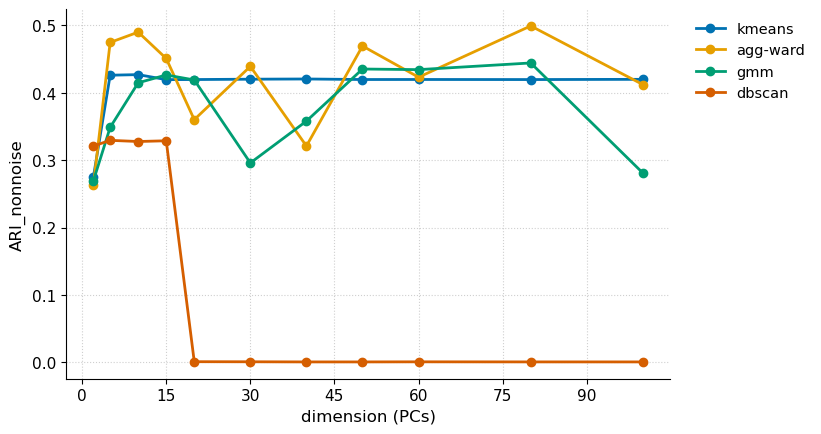

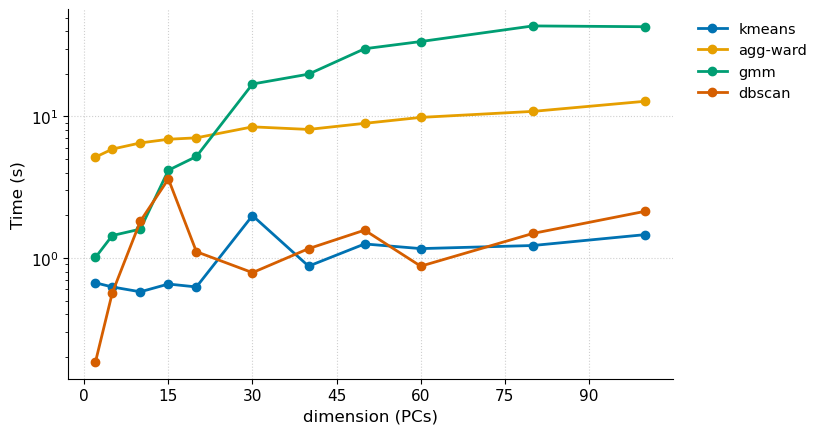

In [27]:
# running all methods on k =6 and dbscan on minpts = 10 to know how methods vary affter declaring k 

Xs_full = StandardScaler().fit_transform(np.vstack([X_tr_raw, X_te_raw]))
recs = []
for d in DIM_CHANGE:
    Xd = PCA(n_components=d, random_state=RANDOM_SEED).fit_transform(Xs_full)

    lab, rt = fit_kmeans_model(Xd, K_TRUE)
    recs.append({"dim": d, "method": "kmeans", "ARI_nonnoise": ari_nonnoise(y_full, lab), "runtime_s": rt})

    lab, rt = fit_ward(Xd, K_TRUE)
    recs.append({"dim": d, "method": "agg-ward", "ARI_nonnoise": ari_nonnoise(y_full, lab), "runtime_s": rt})

    lab, rt = fit_gmm(Xd, K_TRUE)
    recs.append({"dim": d, "method": "gmm", "ARI_nonnoise": ari_nonnoise(y_full, lab), "runtime_s": rt})

    minpts = 10
    eps = estimate_dbscan_eps(Xd, k_neighbors=minpts, q=DBSCAN_Q)
    lab, rt = fit_dbscan(Xd, eps, minpts)
    recs.append({"dim": d, "method": "dbscan", "ARI_nonnoise": ari_nonnoise(y_full, lab), "runtime_s": rt})

dim_df = pd.DataFrame(recs)
display(dim_df)

# ARI vs dim
fig, ax = plt.subplots(figsize=(7.8, 4.8))
for m in ["kmeans", "agg-ward", "gmm", "dbscan"]:
    sub = dim_df[dim_df["method"] == m].sort_values("dim")
    ax.plot(sub["dim"], sub["ARI_nonnoise"], marker="o", linewidth=2, label=m, color=palette[m])
ax.set_xlabel("dimension (PCs)"); ax.set_ylabel("ARI_nonnoise"); style_axes(ax, integer_x=True)
ax.legend(frameon=False, bbox_to_anchor=(1.02, 1.0), loc="upper left")
plt.show()

# Runtime vs dim (log)
fig, ax = plt.subplots(figsize=(7.8, 4.8))
for m in ["kmeans", "agg-ward", "gmm", "dbscan"]:
    sub = dim_df[dim_df["method"] == m].sort_values("dim")
    ax.plot(sub["dim"], sub["runtime_s"], marker="o", linewidth=2, label=m, color=palette[m])
ax.set_yscale("log")
ax.set_xlabel("dimension (PCs)"); ax.set_ylabel("Time (s)"); style_axes(ax, integer_x=True)
ax.legend(frameon=False, bbox_to_anchor=(1.02, 1.0), loc="upper left")
plt.show()
